In [39]:
import sys,os
#import setGPU
import numpy as np
import h5py
import random

from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score
import sklearn
from sklearn.metrics import confusion_matrix
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random

#sys.path.append(os.path.abspath(os.path.join('../ADgvae/')))
from pathlib import Path
from importlib import reload  
import os.path as osp
#sys.path.append(os.path.abspath(os.path.join('../../minisom/')))
#reload(minisom)
#from minisom import MiniSom

sys.path.append(os.path.abspath(os.path.join('../IDEC/')))
import data_utils.data_processing as data_proc
reload(data_proc)
from data_utils.data_processing import GraphDataset, DenseEventDataset
from training_utils.metrics import cluster_acc
from models.models import GraphAE, IDEC 
from training_utils.training import target_distribution,pretrain_ae_graph, train_test_ae_graph,train_test_idec_graph
from training_utils.activation_funcs  import get_activation_func

import torch
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.data import Data, Batch, DataLoader
from data_utils.data_processing import GraphDataset,DenseEventDataset
from training_utils.metrics import cluster_acc

from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score

import matplotlib.colors as colors
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

from sklearn.manifold import TSNE

import matplotlib.colors as colors

sys.path.append(os.path.abspath(os.path.join('../')))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [70]:
batch_size = 256

DATA_PATH='/eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_AD_event_based/run_7/evaluated/'
BG_NAME = 'background_evaluated_model71.h5'
SIG_NAME = 'signals_evaluated_model71.h5'
bg_file = h5py.File(DATA_PATH+BG_NAME)
sig_file = h5py.File(DATA_PATH+SIG_NAME)

In [71]:
bg_dict = {}
sig_dict = {}
loss_names = []
for k in list(bg_file.keys()):
    for f,d in zip([bg_file,sig_file],[bg_dict,sig_dict]):
        d[k] = np.array(f[k])
    if 'Loss' in k: loss_names.append(k)

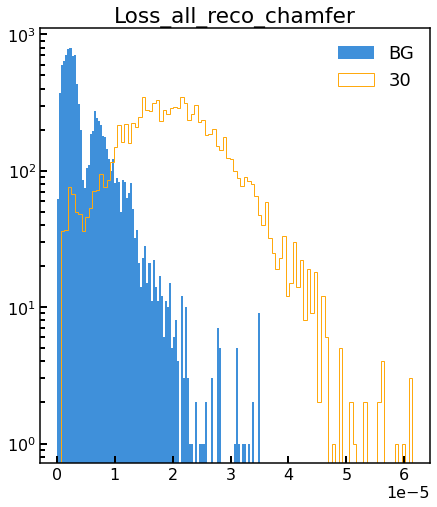

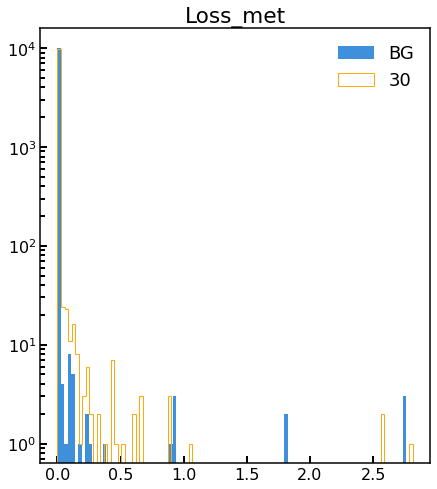

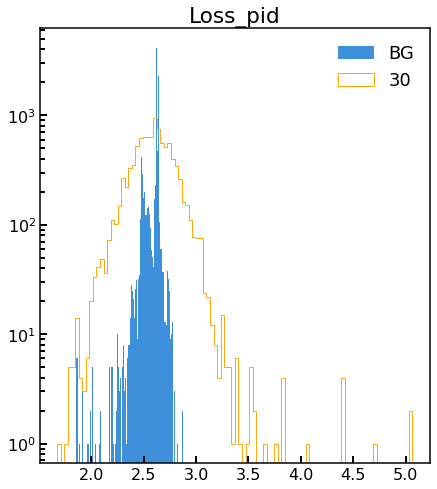

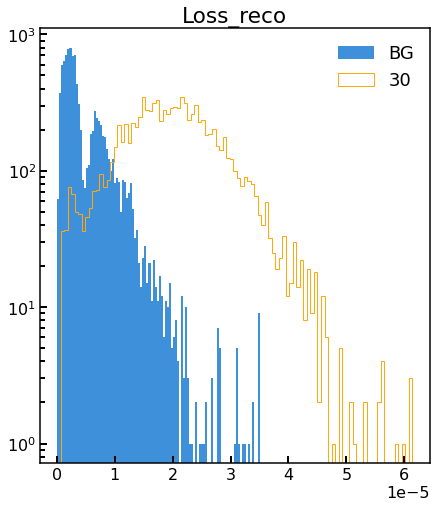

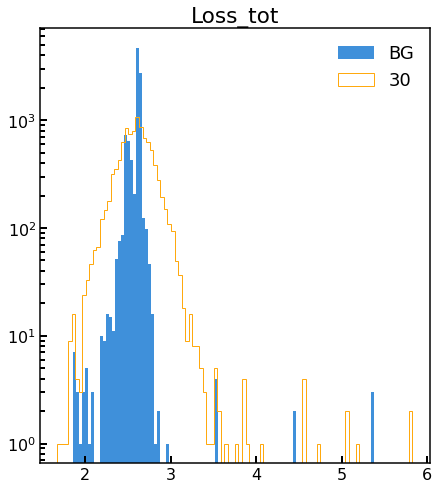

In [43]:
plt_evt = int(1e5)
for loss in loss_names:
    plt.figure()
    _ = plt.hist(bg_dict[loss][:plt_evt],bins=100,label='BG')
    for sig in np.unique(sig_dict['ProcessID'][:,0]):
        _ = plt.hist(sig_dict[loss][sig_dict['ProcessID'][:,0]==sig][:plt_evt],bins=100,histtype='step',label=sig)
    plt.title(loss)
    plt.legend()
    plt.semilogy()

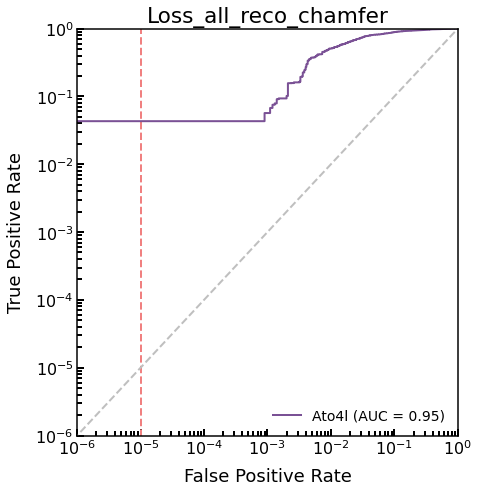

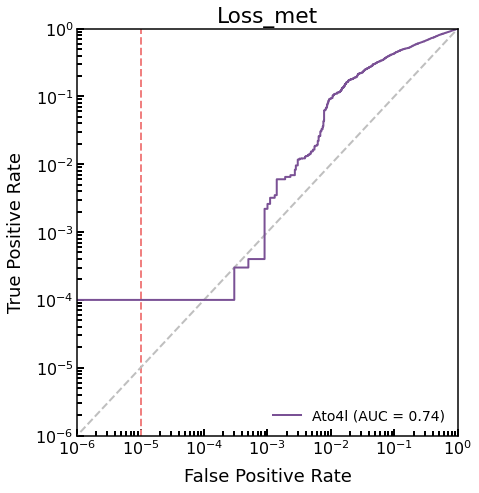

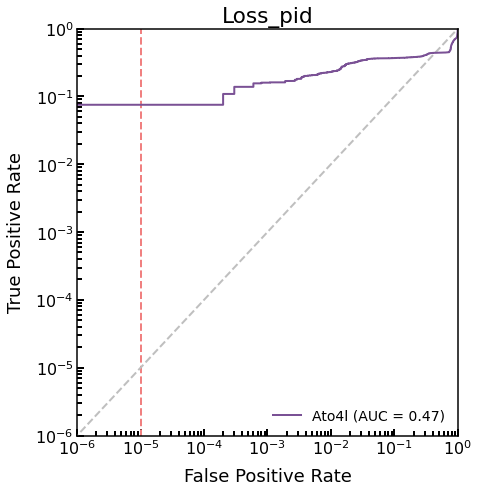

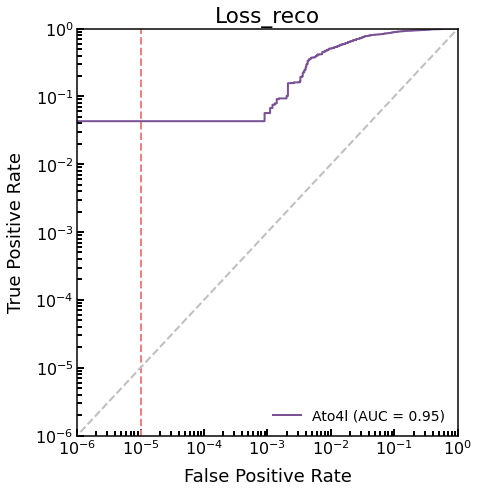

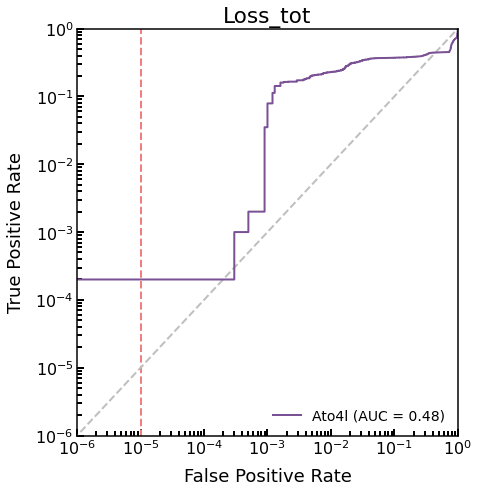

In [44]:
import plotting_utils.util_plotting as util_plt

SIG_NAMES = [data_proc.process_name_dict[s_id] for s_id in np.unique(sig_dict['ProcessID'][:,0])]
for loss in loss_names:
    neg_class_losses,pos_class_losses = util_plt.prepare_neg_pos_losses(bg_dict[loss],sig_dict[loss],sig_dict['ProcessID'])
    util_plt.plot_roc(neg_class_losses, pos_class_losses, legend=SIG_NAMES, title=loss,
            plot_name='test',xlim=1e-6,ylim=1e-6, fig_dir=None,log_x=True ,legend_loc='lower right')
    plt.show()

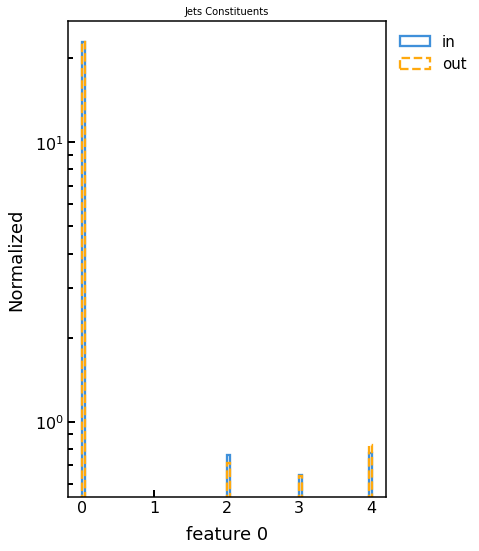

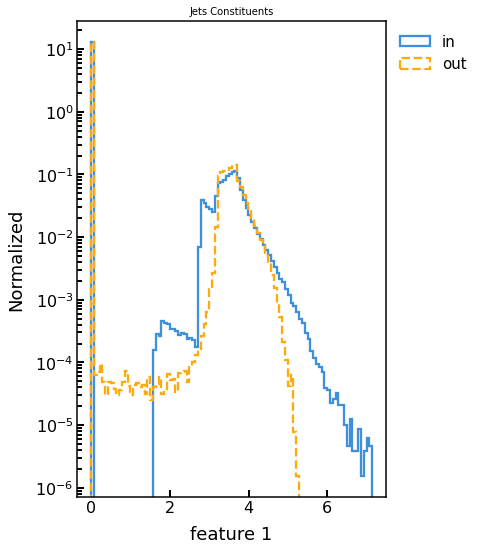

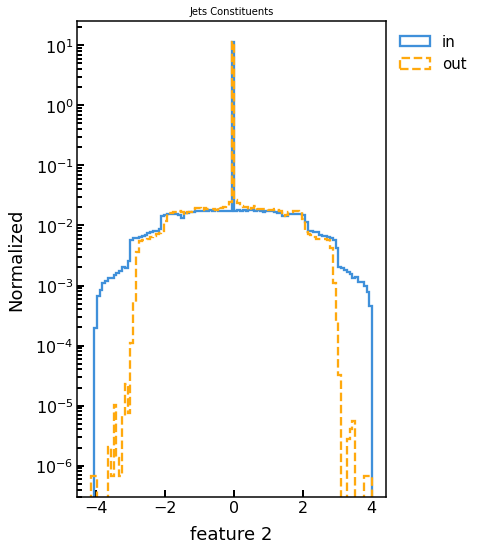

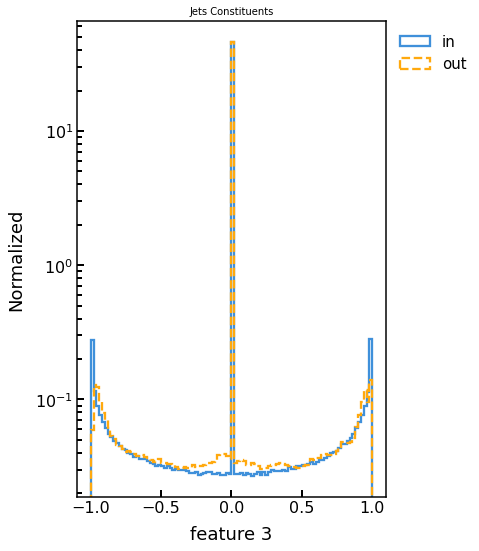

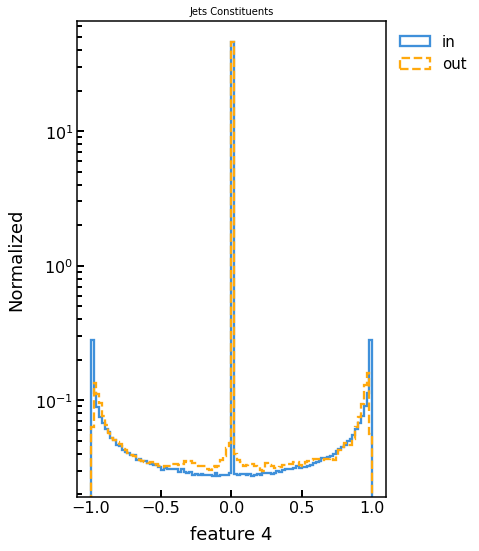

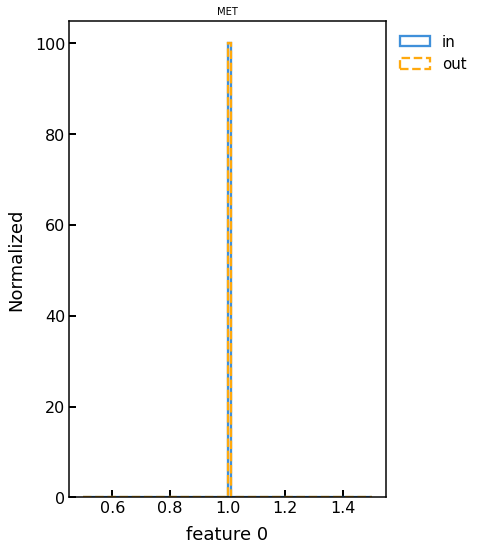

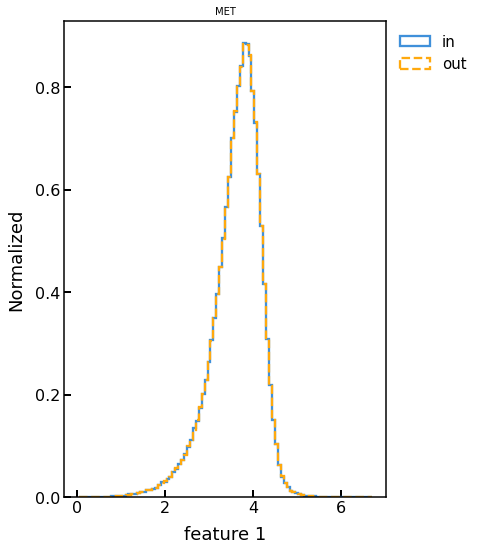

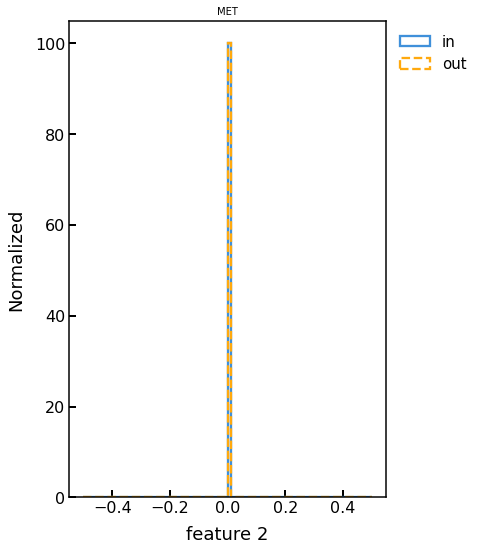

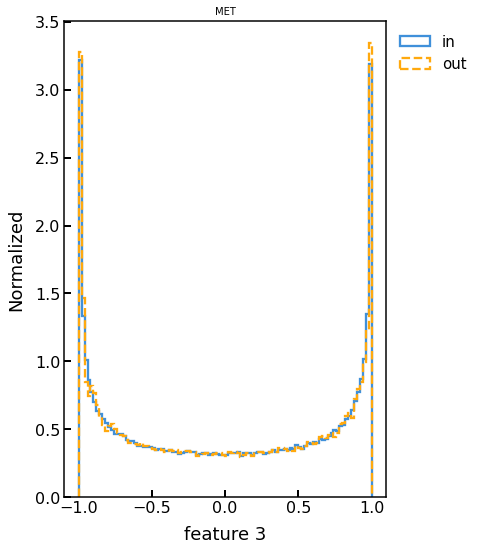

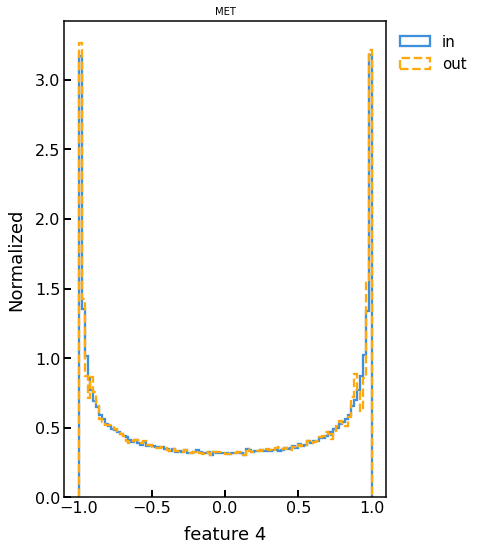

In [72]:
import plotting_utils.util_plotting as util_plt

def reshape_3d_to_2d(ar):
    return ar.reshape((-1,ar.shape[2]))
    

util_plt.plot_features([reshape_3d_to_2d(bg_dict['InputParticles'][:,1:,:]),reshape_3d_to_2d(bg_dict['PredictedParticles'][:,1:,:])], 'feature' ,
                             'Normalized' , 'Jets Constituents', 
                             plotname='test',
                             legend=['in','out'],
                              ylogscale=True)
    
util_plt.plot_features([reshape_3d_to_2d(bg_dict['InputParticles'][:,0:1,:]),reshape_3d_to_2d(bg_dict['PredictedParticles'][:,0:1,:])], 'feature' ,
                             'Normalized' , 'MET', 
                             plotname='test',
                             legend=['in','out'],
                              ylogscale=False)

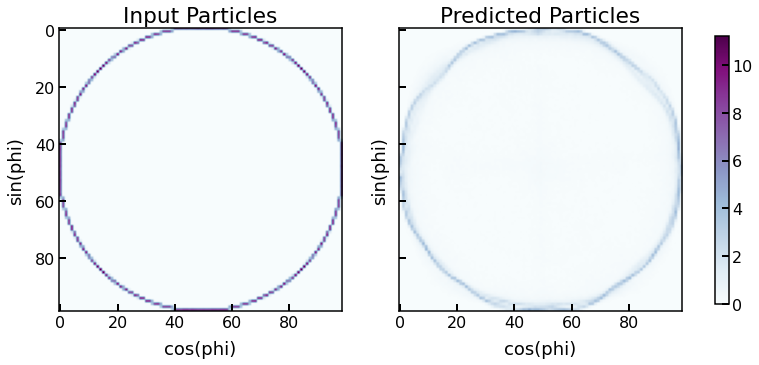

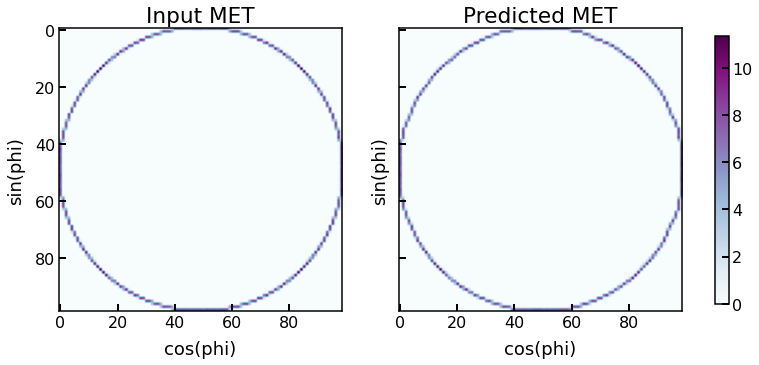

In [94]:

def plot_phi_correlations(input_feats,pred_feats,title=''):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6),sharey=True)
    binning = np.linspace(-1,1,100)
    mappables=[]
    for data in [input_feats,pred_feats]:
        h,xedges,yedges = np.histogram2d(data[:,0], data[:,1], bins=[binning,binning],density=True)
        mappables.append(h)
    vmin = np.min(mappables)
    vmax = np.max(mappables)
    for ax,g in zip(axs.ravel(),mappables):
        im = ax.imshow(g,vmin=vmin, vmax=vmax, cmap=plt.cm.BuPu)
        ax.set_title('Input {}'.format(title))
        ax.set_xlabel('cos(phi)')
        ax.set_ylabel('sin(phi)')
    axs[0].set_title('Input {}'.format(title))
    axs[1].set_title('Predicted {}'.format(title))
    fig.colorbar(im,fraction=0.02*h.shape[1]/h.shape[0] ,ax=axs.ravel())
    #fig.tight_layout()
    plt.show()
    
    
inp_phi = reshape_3d_to_2d(bg_dict['InputParticles'][:,1:,[0,-2,-1]])
inp_phi = inp_phi[inp_phi[:,0]!=0][:,1:]
pred_phi = reshape_3d_to_2d(bg_dict['PredictedParticles'][:,1:,[0,-2,-1]])
pred_phi = pred_phi[pred_phi[:,0]!=0][:,1:]
plot_phi_correlations(inp_phi,pred_phi,title='Particles')

plot_phi_correlations(reshape_3d_to_2d(bg_dict['InputParticles'][:,0:1,[-2,-1]]),\
                      reshape_3d_to_2d(bg_dict['PredictedParticles'][:,0:1,[-2,-1]]),\
                     title='MET')